<h1 align=center><font size = 5>Applied Data Science Capstone</font></h1>

__Hello and Welcome!__

The below script is used for the IBM Applied Data Science Capstone project.  
Hope you will enjoy reading it.

In [1]:
# import needed libraries
import pandas as pd
import numpy as np
import requests
import lxml.html as lh
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# libraries used for clustering and finding the optimal k
from sklearn.cluster import KMeans 
from sklearn import metrics 
from scipy.spatial.distance import cdist 
import matplotlib.pyplot as plt  
from sklearn.metrics import silhouette_score

__Introduction__

In this project we will be analyzing neighborhoods in Budapest and all the different restaurant venues in the city.   
The goal is to cluster the neighborhoods in the city to provide a comprehensive outlook on what kind of restaurants to expect in each district.  

In order to fulfill our goal, we are going to use districts data from [Wikipedia](https://en.wikipedia.org/wiki/List_of_districts_in_Budapest); the work of [Mór Kapronczay](https://github.com/morkapronczay/osm_bp_districts) will be used for the geojson file containing the districts of Budapest; geographical data of district coordinates from [Geodatos](https://www.geodatos.net/en/coordinates/hungary);  and office venues data from [foursquare](https://foursquare.com/).  
We will scrape the data from Wikipedia, put the coordinates data into a .csv and join it with our districts data and use the Foursquare API to GET office venues data.

__Step 1: Data wrangling__
  
__1.1: Web scrapping__  

Let's start with the web scrapping from Wikipedia.

In [2]:
# Set the URL we want to scrape
url='https://en.wikipedia.org/wiki/List_of_districts_in_Budapest'

#Create a handle, page, to handle the contents of the website
page = requests.get(url)

#Store the contents of the website under doc
doc = lh.fromstring(page.content)

#Parse data that are stored between <tr>..</tr> of HTML
tr_elements = doc.xpath('//tr')

In [3]:
# Check the length of the first 12 rows --> this is for sanity check, all rows have to have the same width
[len(T) for T in tr_elements[:12]]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]

In [4]:
# Let's parse the first rows as header
tr_elements = doc.xpath('//tr')

#Create empty list
col=[]
i=0

#For each row, store each first element (header) and an empty list
for t in tr_elements[0]:
    i+=1
    name=t.text_content()
    print( '%d:"%s"'%(i,name))
    col.append((name,[]))

1:"District number
"
2:"District name
"
3:"Neighborhoods
"
4:"Sights
"


In [5]:
#Since our first row is the header, data is stored on the second row onwards
for j in range(1,len(tr_elements)):
    #T is our j'th row
    T=tr_elements[j]
    
    #If row is not of size 3, the //tr data is not from our table 
    if len(T)!=4:
        break
    
    #i is the index of our column
    i=0
    
    #Iterate through each element of the row
    for t in T.iterchildren():
        data=t.text_content() 
        #Check if row is empty
        if i>0:
        #Convert any numerical value to integers
            try:
                data=int(data)
            except:
                pass
        #Append the data to the empty list of the i'th column
        col[i][1].append(data)
        #Increment i for the next column
        i+=1

In [6]:
# Just to be sure, let's check the length of each column --> they should be the same
[len(C) for (title,C) in col]

[24, 24, 24, 24]

In [7]:
# Now we are ready to create our pandas dataframe
Dict={title:column for (title,column) in col}
df=pd.DataFrame(Dict)
df.head()

,District number\n,District name\n,Neighborhoods\n,Sights\n
0,I.\n,Várkerület(Castle District)\n,"Buda Castle, Tabán, Gellérthegy, Krisztinaváro...","Buda Castle, Matthias Church, Hungarian Nation..."
1,II.\n,none\n,"Adyliget, Budakeszierdő, Budaliget, Csatárka, ...","Tomb of Gül Baba, Mechwart Park, Cave of Szeml..."
2,III.\n,Óbuda-Békásmegyer\n,"Óbuda, Aquincum, Aranyhegy, Békásmegyer, Csill...","Ruins of Aquincum, Aquincum Military Amphithea..."
3,IV.\n,Újpest(New Pest)\n,"Újpest, Megyer, Káposztásmegyer, Székesdűlő, I...","Queen of Heavens Church, Synagogue of Újpest, ..."
4,V.\n,Belváros-Lipótváros(Inner City-Leopold Town)\n,"Inner City, Lipótváros\n","Parliament, Hungarian Academy of Sciences, Gre..."


__1.2: Districts data wrangling__  

Great, we have the data! But notice that we have some issues, i.e. '\n' at the end of each record. Let's fix that.

In [8]:
# Let's fix the \n issue; replace the \n with empty string and rename the column
df['District number\n'] = df['District number\n'].str.replace(r'\n', '')
df['District name\n'] = df['District name\n'].str.replace(r'\n', '')
df['Neighborhoods\n'] = df['Neighborhoods\n'].str.replace(r'\n', '')
df['Sights\n'] = df['Sights\n'].str.replace(r'\n', '')
df.rename(columns={"District number\n": "District number","District name\n": "District name",
                   "Neighborhoods\n": "Neighborhoods", "Sights\n": "Sights"}, inplace=True)

Notice that we have one district number in the wrong format and one non-district; let's deal with these issue now by fixing the format and dropping the non-district row. Lastly, for the purpose of this analysis we won't be using the 'Sights' column, so let's drop it.

In [9]:
# Notice the issues
df.tail(6)

,District number,District name,Neighborhoods,Sights
18,XIX. kerület,Kispest(Little Pest),"Kispest, Wekerletelep",Our Lady Church of Kispest
19,XX.,Pesterzsébet(Pest Elizabeth),"Gubacsipuszta, Kossuthfalva, Pacsirtatelep, Pe...","St. Elizabeth of Árpád House Church, Statue of..."
20,XXI.,Csepel,Csepel,"Little Our Lady Church, Tamariska Hill"
21,XXII.,Budafok-Tétény,"Budatétény, Nagytétény, Budafok","Czuba-Durozier Castle, Nagytétény Castle, Sace..."
22,XXIII.,Soroksár,Soroksár,"Heroes' Statue, Molnár Island"
23,non-district,Margit-sziget(Margaret Island),Margit-sziget,"Dominican Monastery ruins, Franciscan Monaster..."


In [10]:
# Now let's handle the 'non-district' value
df = df[df['District number'] != 'non-district']

# Let's replace the 'XIX. kerület' with just 'XIX.'
df.loc[(df['District number'] == 'XIX. kerület'),'District number'] = 'XIX.'

# Let's drop the 'Sights' column as we won't be needing it
df.drop(columns=['Sights'], inplace = True)

# Also let's remove the English names of the districts for visual aesthetics later on.
df['District name'] = df['District name'].str.replace(r'\(.*\)', '')

# Now let's handle to 'None' in District name and let's call it by the district number
df.loc[(df['District name'] == 'none'),'District name'] = df.loc[(df['District name'] == 'none'),'District number']

Now, let's continue with importing coordinates for each district and join it with our districts data.

In [11]:
# import latitutde & longitude data 
coord = pd.read_csv('bud_lat_long.csv')

# We can merge our two dfs based on district nr.
df = df.merge(coord, on = 'District number') # join the grouped df with the regular one

# Let's see our df
df.head()

,District number,District name,Neighborhoods,Latitude,Longitude
0,I.,Várkerület,"Buda Castle, Tabán, Gellérthegy, Krisztinaváro...",47.498551,19.034610
1,II.,II.,"Adyliget, Budakeszierdő, Budaliget, Csatárka, ...",47.519840,19.022181
2,III.,Óbuda-Békásmegyer,"Óbuda, Aquincum, Aranyhegy, Békásmegyer, Csill...",47.541569,19.035010
3,IV.,Újpest,"Újpest, Megyer, Káposztásmegyer, Székesdűlő, I...",47.570821,19.092090
4,V.,Belváros-Lipótváros,"Inner City, Lipótváros",47.499200,19.051500


__1.3: Districts mapping__

First of all, we are going to implement the work of [Mór Kapronczay](https://github.com/morkapronczay/osm_bp_districts). He created a .txt file with the geocoordinates in each district. Let's extract that data using the json_to_geojson function he created.

In [12]:
def json_to_geojson(data, districts):
    # create a geojson from a list of dictionaries
    # containing coordinates with the name of the polygon
    # in our case a polygon is a district
    assert type(data) == list, "The parameter data should be a list of coordinates with a name argument!"
    
    geojson = {
        "type": "FeatureCollection",
        "features": [
        {
            "type": "Feature",
            "geometry" : {
                "type": "Polygon",
                "name": district,
                "coordinates": [[[d["lon"], d["lat"]] for d in data if d['name'] == district]],
                },
            "properties" : {'name': district},
            
         } for district in districts]
    }
    
    return geojson


In [13]:
# load data
with open('district_coords2.txt', 'r') as fp:
    district_coords = json.loads(fp.read())
    
# get a list of districts
districts = list(set([district_coord['name'] for district_coord in district_coords]))

# create a geojson
bp_geojson = json_to_geojson(district_coords, districts)



In [14]:
# create a plain world map
latitude = 47.4850087
longitude = 19.0899094
bp_map = folium.Map(location=[latitude, longitude], tiles = 'OpenStreetMap', zoom_start=11)

# generate choropleth map 
bp_map.choropleth(
    geo_data=bp_geojson,
    fill_color='red', 
    line_color='black',
    fill_opacity=0.3, 
    line_opacity=0.9
)

# add markers to map
for lat, lng, district in zip(df['Latitude'], df['Longitude'], df['District number']):
    label = '{}'.format(district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='Black',
        fill=True,
        fill_color='white',
        fill_opacity=1,
        parse_html=False).add_to(bp_map)

# display map
bp_map

C:\ProgramData\Anaconda3\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


__1.4: GET restaurant venues from FourSquare API__

Finally, let's use the Foursquare API to get restaurant venues data.  
In the foursquare API, all the relevant information is in the 'items'. We will create a function to get the category types out of the json and then continue the analysis.

In [34]:
CLIENT_ID =  # your Foursquare ID
CLIENT_SECRET = # your Foursquare Secret
VERSION = '20191220' # Foursquare API version

In [16]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now let's define a function that will get venues data from all districts.

In [17]:
# The following function will get venues data from all districts:

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&query={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            search_query,
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Cool, now we have the function so let's put it into action by calling it on 'restaruant' venues

In [18]:
LIMIT = 200 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
search_query = 'restaurant'

# Let's pass the function to our dataframe

restaurant_venues = getNearbyVenues(names=df['District name'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )



Várkerület
II.
Óbuda-Békásmegyer
Újpest
Belváros-Lipótváros
Terézváros
Erzsébetváros
Józsefváros
Ferencváros
Kőbánya
Újbuda
Hegyvidék
XIII.
Zugló
XV.
XVI.
Rákosmente
Pestszentlőrinc-Pestszentimre
Kispest
Pesterzsébet
Csepel
Budafok-Tétény
Soroksár


Let's see the amount of rows & columns we have in our new dataframe

In [19]:
# Amount of venues returned per District
print('Our dataframe has the folowing amount of rows & columns: ',restaurant_venues.shape)
restaurant_venues.groupby('District').count()

Our dataframe has the folowing amount of rows & columns:  (1155, 7)


,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
District,,,,,,
Belváros-Lipótváros,100,100,100,100,100,100
Budafok-Tétény,4,4,4,4,4,4
Csepel,17,17,17,17,17,17
Erzsébetváros,100,100,100,100,100,100
Ferencváros,100,100,100,100,100,100
Hegyvidék,70,70,70,70,70,70
II.,24,24,24,24,24,24
Józsefváros,100,100,100,100,100,100
Kispest,19,19,19,19,19,19


In [20]:
# Amount of unique venues in the borough
print('There are {} uniques categories.'.format(len(restaurant_venues['Venue Category'].unique())))

There are 71 uniques categories.


__1.5: Preparation for clustering__

Let's prepare a dataframe for the clustering. To cluster the data with k-means method, we need to onehot encode the categorical variables, since this model can only use numerical data.

In [21]:
# one hot encoding
restaurant_onehot = pd.get_dummies(restaurant_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
restaurant_onehot['District'] = restaurant_venues['District'] 
restaurant_onehot = restaurant_onehot[ ['District'] + [ col for col in restaurant_onehot.columns if col != 'District' ] ]


Now we can group our restaurant based on District and we can get the mean frequency for each category in the district.  
Also, let's print out the top five restaurant types in the city and the per district.

In [46]:
restaurant_onehot.mean().sort_values(ascending=False).head()

Bakery                  0.099567
Restaurant              0.099567
Café                    0.075325
Hungarian Restaurant    0.057143
Chinese Restaurant      0.047619
dtype: float64

In [22]:
restaurant_grouped = restaurant_onehot.groupby('District').mean().reset_index()
num_top_venues = 5

for hood in restaurant_grouped['District']:
    print("----"+hood+"----")
    temp = restaurant_grouped[restaurant_grouped['District'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Belváros-Lipótváros----
                         venue  freq
0                   Restaurant  0.11
1           Italian Restaurant  0.10
2         Hungarian Restaurant  0.09
3   Modern European Restaurant  0.05
4  Eastern European Restaurant  0.05


----Budafok-Tétény----
                 venue  freq
0           Food Stand  0.25
1    German Restaurant  0.25
2       Breakfast Spot  0.25
3          Pizza Place  0.25
4  American Restaurant  0.00


----Csepel----
         venue  freq
0  Pizza Place  0.18
1       Bakery  0.18
2         Café  0.12
3   Restaurant  0.12
4        Diner  0.12


----Erzsébetváros----
                  venue  freq
0            Restaurant  0.09
1  Hungarian Restaurant  0.09
2          Burger Joint  0.07
3                  Café  0.06
4           Pizza Place  0.06


----Ferencváros----
                  venue  freq
0                Bakery  0.11
1          Burger Joint  0.09
2            Restaurant  0.07
3                  Café  0.07
4  Fast Food Restaurant  0.06




Great! Now we have a rough idea on what kind of restaurants can we find in each district. Let's now store the top 10 most frequent restaurant types in a new dataframe.

In [23]:
# function to sort venues in descending
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['District'] = restaurant_grouped['District']

for ind in np.arange(restaurant_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(restaurant_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Belváros-Lipótváros,Restaurant,Italian Restaurant,Hungarian Restaurant,Café,Eastern European Restaurant,Pizza Place,Modern European Restaurant,Bakery,Bistro,Burger Joint
1,Budafok-Tétény,German Restaurant,Pizza Place,Food Stand,Breakfast Spot,Vietnamese Restaurant,Fish & Chips Shop,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Falafel Restaurant
2,Csepel,Bakery,Pizza Place,Diner,Café,Fast Food Restaurant,Restaurant,Asian Restaurant,Sushi Restaurant,Chinese Restaurant,Dumpling Restaurant
3,Erzsébetváros,Restaurant,Hungarian Restaurant,Burger Joint,Pizza Place,Gastropub,Café,Bakery,Bistro,Thai Restaurant,Italian Restaurant
4,Ferencváros,Bakery,Burger Joint,Café,Restaurant,Fast Food Restaurant,Italian Restaurant,Diner,Vietnamese Restaurant,Chinese Restaurant,Falafel Restaurant


__2: Data clustering__

We have arrived to the interesing part of this analysis: clustering!  
We will cluster our data into 5 segments and map them using folium choropleth.

__2.1: Finding the optimum k__

Our first task before fitting our model to the dataset is to find the optimal number of clusters. For this, we will first use the elbow method, which uses the Within-cluster-sum of squared errors. If using this method doesn't provide us with a clear idea on which k to use, we will utilize the silhouette method and use the k with the lowest score before it start rising again.

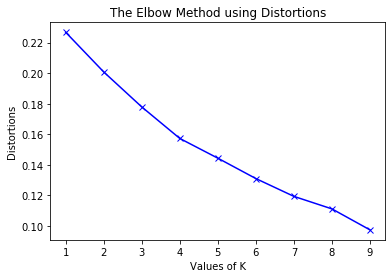

In [24]:
# Let's first create a df that we will use for clustering
restaurant_grouped_clustering = restaurant_grouped.drop('District', 1)

# Now let's define variables for the elbow method and let's plot the result
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(restaurant_grouped_clustering) 
    kmeanModel.fit(restaurant_grouped_clustering)     
      
    distortions.append(sum(np.min(cdist(restaurant_grouped_clustering, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / restaurant_grouped_clustering.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(restaurant_grouped_clustering, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / restaurant_grouped_clustering.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

    


plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortions') 
plt.title('The Elbow Method using Distortions') 
plt.show() 


The elbow method doesn't provide us a clear idea on which k to use, therefore, we must utilize the silhouette method instead.

In [25]:
#Use silhouette score
range_n_clusters = list (range(2,10))
print ("Number of clusters from 2 to 9: \n", range_n_clusters)

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(restaurant_grouped_clustering)
    centers = clusterer.cluster_centers_

    score = silhouette_score (restaurant_grouped_clustering, preds, metric='euclidean')
    print ("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

Number of clusters from 2 to 9: 
 [2, 3, 4, 5, 6, 7, 8, 9]
For n_clusters = 2, silhouette score is 0.3059191122129161
For n_clusters = 3, silhouette score is 0.32996039213204165
For n_clusters = 4, silhouette score is 0.33168044404685765
For n_clusters = 5, silhouette score is 0.10295251674768416
For n_clusters = 6, silhouette score is 0.09725926562427908
For n_clusters = 7, silhouette score is 0.09638320231133281
For n_clusters = 8, silhouette score is 0.09963720118065698
For n_clusters = 9, silhouette score is 0.09562995716820394


__2.2: Model fitting__

From the silhouette score we see that the best k = 4, now we can proceed to fitting our model to the df.

In [26]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=42).fit(restaurant_grouped_clustering)

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

restaurant_merged = df
df.rename(columns={"District name": "District"}, inplace = True)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
restaurant_merged = restaurant_merged.join(neighborhoods_venues_sorted.set_index('District'), on='District')


__2.3: Cluster analysis__  

Let's take a look at each cluster one by one and try to figure out the common descriptor of them.

In [27]:
restaurant_merged.loc[restaurant_merged['Cluster Labels'] == 0, restaurant_merged.columns[[1] + list(range(5, restaurant_merged.shape[1]))]]

,District,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Várkerület,0,Hungarian Restaurant,Restaurant,Café,Bakery,Bistro,Chinese Restaurant,Eastern European Restaurant,Italian Restaurant,Breakfast Spot,French Restaurant
1,II.,0,Restaurant,Deli / Bodega,Café,Hungarian Restaurant,Italian Restaurant,Bakery,Breakfast Spot,Food Truck,Middle Eastern Restaurant,Chinese Restaurant
2,Óbuda-Békásmegyer,0,Bakery,Restaurant,Café,Burger Joint,Asian Restaurant,Diner,Turkish Restaurant,Pizza Place,Eastern European Restaurant,Hungarian Restaurant
3,Újpest,0,Bakery,Pizza Place,Café,Restaurant,Hungarian Restaurant,Fast Food Restaurant,Diner,Deli / Bodega,Food Truck,Breakfast Spot
4,Belváros-Lipótváros,0,Restaurant,Italian Restaurant,Hungarian Restaurant,Café,Eastern European Restaurant,Pizza Place,Modern European Restaurant,Bakery,Bistro,Burger Joint
5,Terézváros,0,Italian Restaurant,Restaurant,Café,Pizza Place,Hungarian Restaurant,Burger Joint,Gastropub,Indian Restaurant,Vietnamese Restaurant,Thai Restaurant
6,Erzsébetváros,0,Restaurant,Hungarian Restaurant,Burger Joint,Pizza Place,Gastropub,Café,Bakery,Bistro,Thai Restaurant,Italian Restaurant
7,Józsefváros,0,Burger Joint,Café,Bistro,Hungarian Restaurant,Italian Restaurant,Bakery,Diner,Pizza Place,Chinese Restaurant,Indian Restaurant
8,Ferencváros,0,Bakery,Burger Joint,Café,Restaurant,Fast Food Restaurant,Italian Restaurant,Diner,Vietnamese Restaurant,Chinese Restaurant,Falafel Restaurant
10,Újbuda,0,Chinese Restaurant,Café,Bakery,Fast Food Restaurant,Restaurant,Gastropub,Vegetarian / Vegan Restaurant,Pizza Place,Sandwich Place,Vietnamese Restaurant


It seems like most of the districts belong to this cluster. Here one can find a variety of different types of restaurants.

In [28]:
restaurant_merged.loc[restaurant_merged['Cluster Labels'] == 1, restaurant_merged.columns[[1] + list(range(5, restaurant_merged.shape[1]))]]

,District,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,XV.,1,Bakery,Fast Food Restaurant,Deli / Bodega,Hungarian Restaurant,Restaurant,Greek Restaurant,Bavarian Restaurant,Dumpling Restaurant,German Restaurant,Asian Restaurant
16,Rákosmente,1,Bakery,Burger Joint,Restaurant,Chinese Restaurant,Café,Food,Eastern European Restaurant,Falafel Restaurant,Fast Food Restaurant,Fish & Chips Shop
19,Pesterzsébet,1,Bakery,Chinese Restaurant,Fast Food Restaurant,Asian Restaurant,BBQ Joint,Falafel Restaurant,Diner,Cafeteria,Café,Vietnamese Restaurant
22,Soroksár,1,Bakery,Hungarian Restaurant,Restaurant,Diner,Vietnamese Restaurant,Fish & Chips Shop,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Falafel Restaurant


The second cluster can be defined by having bakeries as most common restaurant venue.

In [29]:
restaurant_merged.loc[restaurant_merged['Cluster Labels'] == 2, restaurant_merged.columns[[1] + list(range(5, restaurant_merged.shape[1]))]]

,District,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,Budafok-Tétény,2,German Restaurant,Pizza Place,Food Stand,Breakfast Spot,Vietnamese Restaurant,Fish & Chips Shop,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Falafel Restaurant


In [30]:
restaurant_merged.loc[restaurant_merged['Cluster Labels'] == 3, restaurant_merged.columns[[1] + list(range(5, restaurant_merged.shape[1]))]]

,District,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Kőbánya,3,Pizza Place,Deli / Bodega,Bakery,Chinese Restaurant,Food,Dumpling Restaurant,Eastern European Restaurant,Falafel Restaurant,Fast Food Restaurant,Fish & Chips Shop


The last two clusters barely contain any restaurants data, therefore it is hard to describe them. There is need for further analysis in terms of neighborhood data rather than an aggregate district level.  

__2.4: Cluster mapping with restaurant venues__  

Lastly, we will create a choropleth map containing the clusters with different colors and the restaurant venues around the district centroids.

In [31]:
# create df that contains venue coordinates, category and cluster labels for mapping
temp1 = restaurant_venues[['District', 'Venue Latitude', 'Venue Longitude', 'Venue Category']]
temp2 = restaurant_merged[['District', 'Cluster Labels']]
rest_clusters = temp1.merge(temp2, on = 'District')
rest_clusters

# create a plain world map
rt_map = folium.Map(location=[latitude, longitude], tiles = 'OpenStreetMap', zoom_start=11)

# generate choropleth map 
folium.Choropleth(
    geo_data=bp_geojson,
    name='choropleth',
    data=restaurant_merged,
    columns=['District number', 'Cluster Labels'],
    key_on='feature.properties.name',
    fill_color='Set1',
    line_color='black',
    fill_opacity=0.4,
    line_opacity=0.8,
    legend_name='Restaurant Clusters'
).add_to(rt_map)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(rest_clusters['Venue Latitude'], rest_clusters['Venue Longitude'],
                                  rest_clusters['Venue Category'], rest_clusters['Cluster Labels']):
    label = folium.Popup(str(poi) + '; Cluster ' + str(cluster), parse_html=True)
    folium.Circle(
        [lat, lon],
        radius=1,
        popup=label,
        color='Black',
        fill=True,
        fill_color='Black',
        fill_opacity=1).add_to(rt_map)
       
# add markers to map
for lat, lng, district in zip(restaurant_merged['Latitude'], restaurant_merged['Longitude'], restaurant_merged['District']):
    label = '{}'.format(district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='Black',
        fill=True,
        fill_color='white',
        fill_opacity=1,
        parse_html=False).add_to(rt_map)
        
# display map
rt_map